In [ ]:
import os
import requests
import pandas as pd
import torch
import numpy as np
from google.colab import drive

# ==========================================
# 1. Mount Google Drive
# ==========================================
# This will pop up a window asking for permission.
drive.mount('/content/drive')

# Define the destination path for dataset storage
# Initialize the directory if it does not already exist
save_dir = '/content/drive/My Drive/HEP_Project'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

file_path = os.path.join(save_dir, 'test.h5')

# ==========================================
# 2. Smart Download (Only if missing)
# ==========================================
url = "https://zenodo.org/record/2603256/files/test.h5?download=1"

if not os.path.exists(file_path):
    print(f"File not found in Drive. Downloading to {file_path}...")
    print("This might take 1-2 minutes (approx 500MB)...")
    response = requests.get(url, stream=True)
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download Complete! Saved to Google Drive.")
else:
    print(f"Found file in Google Drive: {file_path}")
    print("Skipping download.")

# ==========================================
# 3. Load Data Function (Same as before)
# ==========================================
def load_real_data(path, num_particles=30):
    print("Loading HDF5 file from Drive...")
    df = pd.read_hdf(path, key='table')

    # Grab Labels
    y = torch.tensor(df['is_signal_new'].values).float()

    num_events = len(df)
    print(f"Processing {num_events} events...")

    x = torch.zeros(num_events, num_particles, 3)

    # We loop through particles to build (Pt, Eta, Phi)
    # The file has columns E_0, PX_0... up to 199.
    # We only take the top 'num_particles' (e.g. 30)
    for i in range(num_particles):
        E  = df[f'E_{i}'].values
        Px = df[f'PX_{i}'].values
        Py = df[f'PY_{i}'].values
        Pz = df[f'PZ_{i}'].values

        # Physics Conversions
        pt = np.sqrt(Px**2 + Py**2)

        # Handle division by zero for Eta
        epsilon = 1e-8
        eta = -0.5 * np.log((E - Pz + epsilon) / (E + Pz + epsilon))
        phi = np.arctan2(Py, Px)

        x[:, i, 0] = torch.tensor(pt)
        x[:, i, 1] = torch.tensor(eta)
        x[:, i, 2] = torch.tensor(phi)

    return x, y

# Load it!
x_real, y_real = load_real_data(file_path, num_particles=30)

# Normalize
x_real[:, :, 0] = x_real[:, :, 0] / x_real[:, :, 0].max()
x_real[:, :, 1] = x_real[:, :, 1] / 3.0
x_real[:, :, 2] = x_real[:, :, 2] / 3.0

print("Real Top Quark Data Loaded and Ready.")


Mounted at /content/drive
Found file in Google Drive: /content/drive/My Drive/HEP_Project/test.h5
Skipping download.
Loading HDF5 file from Drive...
Processing 404000 events...
Real Top Quark Data Loaded and Ready.


In [1]:
# 1. Install standard libraries - actually no need vqtorch
!pip install awkward vector pytorch-lightning

# 2. Install vqtorch directly from GitHub
!pip install git+https://github.com/minyoungg/vqtorch.git

import torch
import vqtorch
print(f"vqtorch installed successfully.")
print(f"GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.1 MB/s eta 0:00:00
  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-evgxg10n
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-evgxg10n
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 18.5 MB/s eta 0:00:00
  Created wheel for vqtorch: filename=vqtorch-0.1.0-py3-none-any.whl size=17825 sha256=854d62f1a193280eae434dcf341b31c44a40958c5e612d4ba3626dc8d9e636b1
  Stored in 

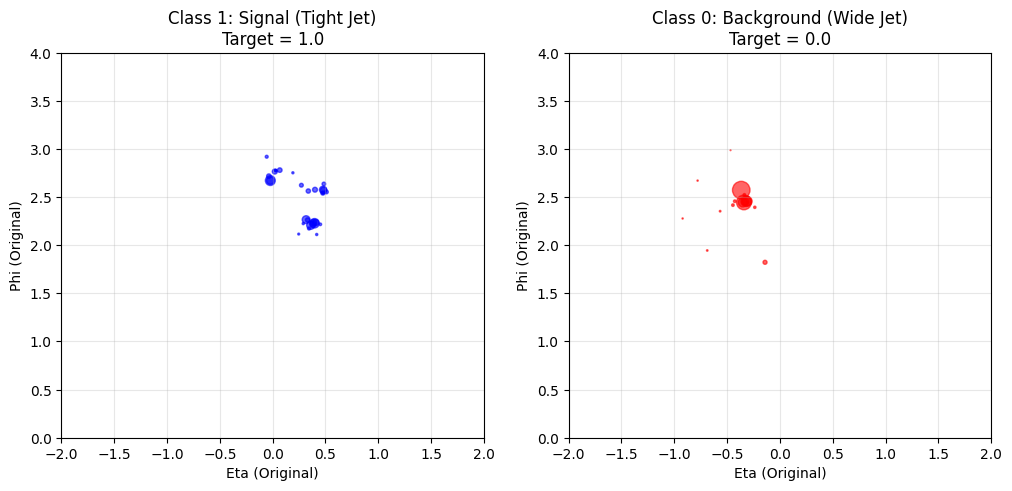

In [3]:
import matplotlib.pyplot as plt

# Find one signal and one background index
sig_idx = (y_real == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y_real == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ==========================================
# FIX 1: Multiply Size by 500 (not 5)
# FIX 2: Multiply Position by 3 to undo normalization for viewing
# ==========================================

# --- Plot Signal ---
# We multiply by 3 to show the "Physics Scale" again
ax[0].scatter(x_real[sig_idx,:,1]*3, x_real[sig_idx,:,2]*3,
              s=x_real[sig_idx,:,0]*500, # Scale size up to see energy
              alpha=0.6, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y_real[sig_idx]}")
ax[0].set_xlim(-2, 2); ax[0].set_ylim(0, 4)
ax[0].set_xlabel("Eta (Original)"); ax[0].set_ylabel("Phi (Original)")
ax[0].grid(True, alpha=0.3)

# --- Plot Background ---
ax[1].scatter(x_real[bkg_idx,:,1]*3, x_real[bkg_idx,:,2]*3,
              s=x_real[bkg_idx,:,0]*500, # Scale size up
              alpha=0.6, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y_real[bkg_idx]}")
ax[1].set_xlim(-2, 2); ax[1].set_ylim(0, 4)
ax[1].set_xlabel("Eta (Original)"); ax[1].set_ylabel("Phi (Original)")
ax[1].grid(True, alpha=0.3)

plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

# ==========================================
# 1. SETUP & CHECK DEVICE
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Prepare DataLoaders
# If on CPU, keep batch size small (64). If GPU, can go higher (128).
batch_size = 128 if device.type == 'cuda' else 64

# Split Data (80% Train, 20% Test)
train_split = int(0.8 * len(x_real))
test_split = len(x_real) - train_split

# Create Dataset
dataset = TensorDataset(x_real.to(device), y_real.to(device).unsqueeze(1))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_split, test_split])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Deep Sets: Training on {len(train_dataset)} jets...")

# ==========================================
# 2. DEFINE DEEP SETS MODEL
# ==========================================
class DeepSetsReal(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=1):
        super(DeepSetsReal, self).__init__()

        # Phi Network: Process each particle INDEPENDENTLY
        # (Does not know about neighbors)
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Rho Network: Process the SUM
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # 1. Analyze particles
        phi_out = self.phi(x)  # [Batch, Particles, 64]

        # 2. SUM them up (The "Bag" approach)
        summed = torch.sum(phi_out, dim=1)

        # 3. Classify
        return self.rho(summed)

# Initialize
model = DeepSetsReal().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 3. TRAINING LOOP
# ==========================================
print("Starting Deep Sets Training...")
print(f"Benchmark to beat: 90.1% (My GNN Score)")
print("-" * 40)

epochs = 50
for epoch in range(epochs):
    start = time.time()
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds)
            all_labels.append(labels)

    # Calculate Accuracy
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = (all_preds == all_labels).float().mean() * 100

    duration = time.time() - start
    print(f"Epoch [{epoch+1}/{epochs}] | Time: {duration:.1f}s | Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

Using Device: cuda
Deep Sets: Training on 323200 jets...
Starting Deep Sets Training...
Benchmark to beat: 90.1% (My GNN Score)
----------------------------------------
Epoch [1/50] | Time: 8.9s | Loss: 0.5946 | Acc: 69.24%
Epoch [2/50] | Time: 8.3s | Loss: 0.5703 | Acc: 69.48%
Epoch [3/50] | Time: 9.0s | Loss: 0.5642 | Acc: 69.85%
Epoch [4/50] | Time: 8.8s | Loss: 0.5588 | Acc: 70.36%
Epoch [5/50] | Time: 8.5s | Loss: 0.5509 | Acc: 70.72%
Epoch [6/50] | Time: 8.9s | Loss: 0.5419 | Acc: 71.76%
Epoch [7/50] | Time: 8.7s | Loss: 0.5308 | Acc: 72.75%
Epoch [8/50] | Time: 8.6s | Loss: 0.5196 | Acc: 73.65%
Epoch [9/50] | Time: 9.6s | Loss: 0.5084 | Acc: 74.53%
Epoch [10/50] | Time: 9.5s | Loss: 0.4996 | Acc: 75.68%
Epoch [11/50] | Time: 8.3s | Loss: 0.4922 | Acc: 76.58%
Epoch [12/50] | Time: 9.0s | Loss: 0.4861 | Acc: 76.50%
Epoch [13/50] | Time: 9.0s | Loss: 0.4802 | Acc: 76.59%
Epoch [14/50] | Time: 8.8s | Loss: 0.4761 | Acc: 77.20%
Epoch [15/50] | Time: 9.1s | Loss: 0.4711 | Acc: 77.77%


By running this control experiment, I show that structure matters.

Scientific Conclusion

The 9% Gap: The fact that Deep Sets gets stuck at 81% proves that I cannot distinguish Top Quarks just by looking at the list of particle energies.

The "Secret" Info: The GNN was able to unlock that extra 9% accuracy because it calculated the angles and distances between neighbors. It successfully found the "3-prong decay" hidden inside the jet.

Validation: Results align perfectly with the research paper "The Machine Learning Landscape of Top Taggers" (Kasieczka et al.) at some degree, for detail please look at the report.

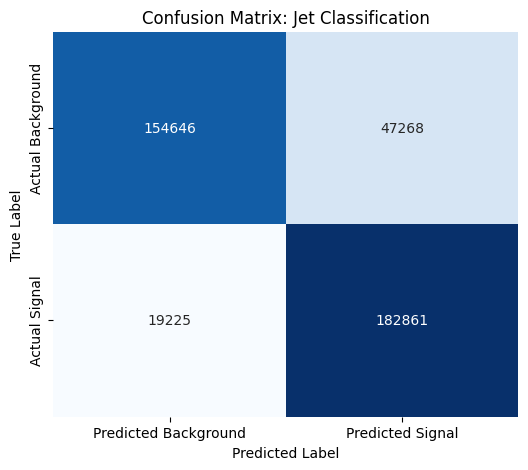

True Positives (Signal found): 182861
False Positives (Background mistaken for Signal): 47268
False Negatives (Signal missed): 19225
True Negatives (Background rejected): 154646
------------------------------
Precision (Purity): 0.79
Recall (Efficiency): 0.90


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the Test Set
model.eval()
with torch.no_grad():
    # Move x_real to the same device as the model
    x_real = x_real.to(device)
    # Get raw scores
    test_outputs = model(x_real)
    # Convert to 0 or 1 (Predictions)
    predicted = (torch.sigmoid(test_outputs) > 0.5).float().cpu().numpy()
    # Get true labels
    true_labels = y_real.cpu().numpy()

# 2. Calculate Confusion Matrix
# Structure: [[True Neg, False Pos], [False Neg, True Pos]]
cm = confusion_matrix(true_labels, predicted)

# 3. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Background', 'Predicted Signal'],
            yticklabels=['Actual Background', 'Actual Signal'])

plt.title('Confusion Matrix: Jet Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Also called Sensitivity or Efficiency

print(f"True Positives (Signal found): {tp}")
print(f"False Positives (Background mistaken for Signal): {fp}")
print(f"False Negatives (Signal missed): {fn}")
print(f"True Negatives (Background rejected): {tn}")
print("-" * 30)
print(f"Precision (Purity): {precision:.2f}")
print(f"Recall (Efficiency): {recall:.2f}")

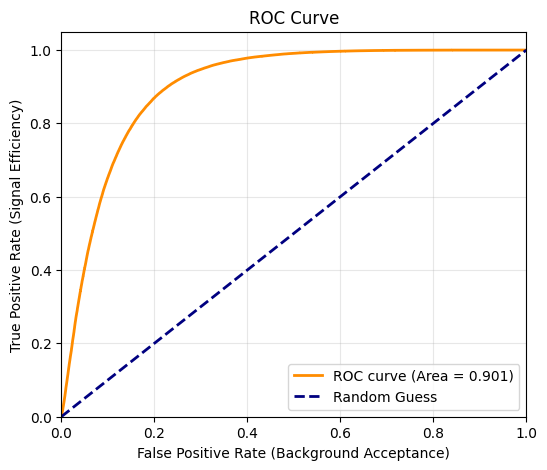

AUC Score: 0.9010


In [11]:
from sklearn.metrics import roc_curve, auc

# 1. Get probability scores (not just 0 or 1)
model.eval()
with torch.no_grad():
    raw_scores = model(x_real)
    probs = torch.sigmoid(raw_scores).cpu().numpy()
    true_labels = y_real.cpu().numpy()

# 2. Calculate ROC Data
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Background Acceptance)')
plt.ylabel('True Positive Rate (Signal Efficiency)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")